In [13]:
import re
import os
import csv

from scipy.interpolate import griddata
from pykrige.ok import OrdinaryKriging
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

In [14]:
def is_numeric(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

In [15]:
images_directory = "GreenBeadsIMG4R" 

In [16]:
cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", ["darkblue", "lightblue", "lightgreen", "orange", "red"])

vmin = 0
vmax = 2

In [26]:
items = os.listdir(images_directory)
image_folders = [item for item in items if os.path.isdir(os.path.join(images_directory, item)) and re.match(r'^Image \d+$', item)]

beads_list = []

for image in image_folders:
    image_path = os.path.join(images_directory, image)
    bead_folders = [item for item in os.listdir(image_path) if os.path.isdir(os.path.join(image_path, item)) and re.match(r'^bead\d+$', item)]

    for bead in bead_folders:
        data_folder = f"{images_directory}_{image}_{bead}_data"
        file_path = os.path.join(image_path, bead, data_folder)
        xls_file_path = os.path.join(file_path, f"{images_directory}_{image}_{bead}_results.xls")
        
        try:
            with open(xls_file_path, 'r') as file:
                data = file.read()
                
                result = {
                    "Image": image,
                    "Bead": bead,
                    "Mes./theory ratio": {},
                    "Fit Goodness": {},
                    "Lateral Asymmetry": None,
                    "Bead coordinates (pixels)": {}
                }
            
                lines = data.split('\n')
                resolution_table_start = False
                lateral_asymmetry_table_start = False
                
                for line in lines:
                    
                    if "Bead original coordinates(in pixels)" in line:
                        coords = line.split('\t')[2].strip()
                        if coords:
                            try:
                                x, y = map(float, coords.split(', '))
                                result["Bead coordinates (pixels)"]["X"] = x
                                result["Bead coordinates (pixels)"]["Y"] = y
                            except ValueError:
                                print(f"Invalid coordinates for {image}/{bead}")
                                
                    if "Resolution" in line:
                        resolution_table_start = True
                        continue

                    if resolution_table_start and line.strip() and line.split("\t")[0] != "Channel":
                        parts = line.split('\t')
                        if len(parts) >= 7:
                            dimension = parts[2]
                            ratio = parts[6]
                            fit_goodness = parts[5]
                            if is_numeric(ratio):
                                ratio_value = float(ratio)
                                result["Fit Goodness"][dimension] = fit_goodness
                                result["Mes./theory ratio"][dimension] = ratio_value
                                

                                                    
                    if "Lateral Asymmetry" in line:
                        lateral_asymmetry_table_start = True
                        continue
                    
                    if lateral_asymmetry_table_start and line.strip().startswith("Channel 0") and line.strip():
                        parts = line.split('\t')
                        if len(parts) >= 2:
                            asymmetry = parts[1]
                            if is_numeric(asymmetry):
                                asymmetry_value = float(asymmetry)
                                result["Lateral Asymmetry"] = asymmetry_value
                        break  
                    
            beads_list.append(result)

        except FileNotFoundError:
            print(f"\nError: {xls_file_path} not found")
        except Exception as e:
            print(f"\nError processing {xls_file_path}: {str(e)}")

def is_valid_bead(bead):
    if 'Mes./theory ratio' not in bead or 'Fit Goodness' not in bead:
        return False
    
    for dimension in ['X', 'Y', 'Z']:
        if (dimension not in bead['Mes./theory ratio'] or
            dimension not in bead['Fit Goodness'] or
            bead['Mes./theory ratio'][dimension] == '' or
            bead['Fit Goodness'][dimension] == '' or
            float(bead['Fit Goodness'][dimension]) < 0.9):
            return False
    
    return True

complete_beads = [bead for bead in beads_list if is_valid_bead(bead)]
incomplete_beads = [bead for bead in beads_list if not is_valid_bead(bead)]

print([bead['Mes./theory ratio']["X"] for bead in complete_beads])

[1.74, 1.55, 1.47, 1.55, 1.53, 1.58, 1.54, 1.41, 1.57, 1.46, 1.43, 1.5, 1.55, 1.5, 1.53, 1.58, 1.55, 1.55, 1.51, 1.56, 1.56, 1.48, 1.58, 1.41, 1.57, 1.52, 1.52, 1.4, 1.43, 1.48, 1.45, 1.43, 1.44, 1.45, 1.45, 1.45, 1.41, 1.44, 1.44, 1.43, 1.43, 1.54, 1.45, 1.43, 1.5, 1.46, 1.46, 1.45, 1.46, 1.38, 1.47, 1.47, 1.41, 1.47, 1.57, 1.43, 1.44, 1.37, 1.39, 1.63, 1.47, 1.44, 1.43, 1.42, 1.44, 1.44, 1.43, 1.45, 1.41, 1.41, 1.44, 1.6, 1.45, 1.43, 4.86, 1.42, 1.46, 1.43, 1.43, 1.38, 1.42, 1.4, 1.44, 1.4, 1.42, 1.43, 1.45, 1.45, 1.41, 1.41, 1.4, 1.44, 1.42, 1.39, 1.44, 1.46, 1.45, 1.46, 1.48, 1.57, 1.44, 1.41, 1.51, 1.42, 1.43, 1.48, 1.42, 1.47, 1.39, 1.55, 1.46, 1.43, 1.42, 1.44, 1.41, 1.4, 1.44, 1.57, 1.41, 1.45, 1.45, 1.63, 1.58, 1.45, 1.89, 1.43, 1.41, 1.43, 1.49, 1.42, 1.54, 1.41, 1.44, 2.09, 1.45, 1.42, 1.41, 1.88, 1.44, 1.42, 1.97, 1.42, 1.6, 1.47, 1.44, 1.43, 1.54, 1.42, 1.48, 1.45, 1.48, 1.43, 1.45, 1.4, 1.47, 1.46, 1.53, 1.51, 1.48, 1.43, 1.48, 1.45, 1.36, 1.5, 1.48, 1.43, 1.44, 1.44, 1.4

In [27]:
# Prepare the CSV file
csv_filename = f"{images_directory}_bead_data.csv"

# Open the CSV file and write the data
with open(csv_filename, 'w', newline='') as csvfile:
    # Define the fieldnames
    fieldnames = ['Image', 'Bead', 'Mes./theory ratio X', 'Mes./theory ratio Y', 'Mes./theory ratio Z',
                  'Lateral Asymmetry', 'Bead coordinates X (pixels)', 'Bead coordinates Y (pixels)']
    
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header
    writer.writeheader()
    
    # Write the data
    for item in complete_beads:
        row = {
            'Image': item['Image'],
            'Bead': item['Bead'],
            'Mes./theory ratio X': item['Mes./theory ratio'].get('X', ''),
            'Mes./theory ratio Y': item['Mes./theory ratio'].get('Y', ''),
            'Mes./theory ratio Z': item['Mes./theory ratio'].get('Z', ''),
            'Lateral Asymmetry': item['Lateral Asymmetry'],
            'Bead coordinates X (pixels)': item['Bead coordinates (pixels)']['X'],
            'Bead coordinates Y (pixels)': item['Bead coordinates (pixels)']['Y']
        }
        writer.writerow(row)

print(f"CSV file '{csv_filename}' has been created successfully.")

CSV file 'GreenBeadsIMG4R_bead_data.csv' has been created successfully.


In [34]:
#Kirging Interpolation
variogram_model = "gaussian" #linear, power, gaussian, spherical, exponential, hole-effect

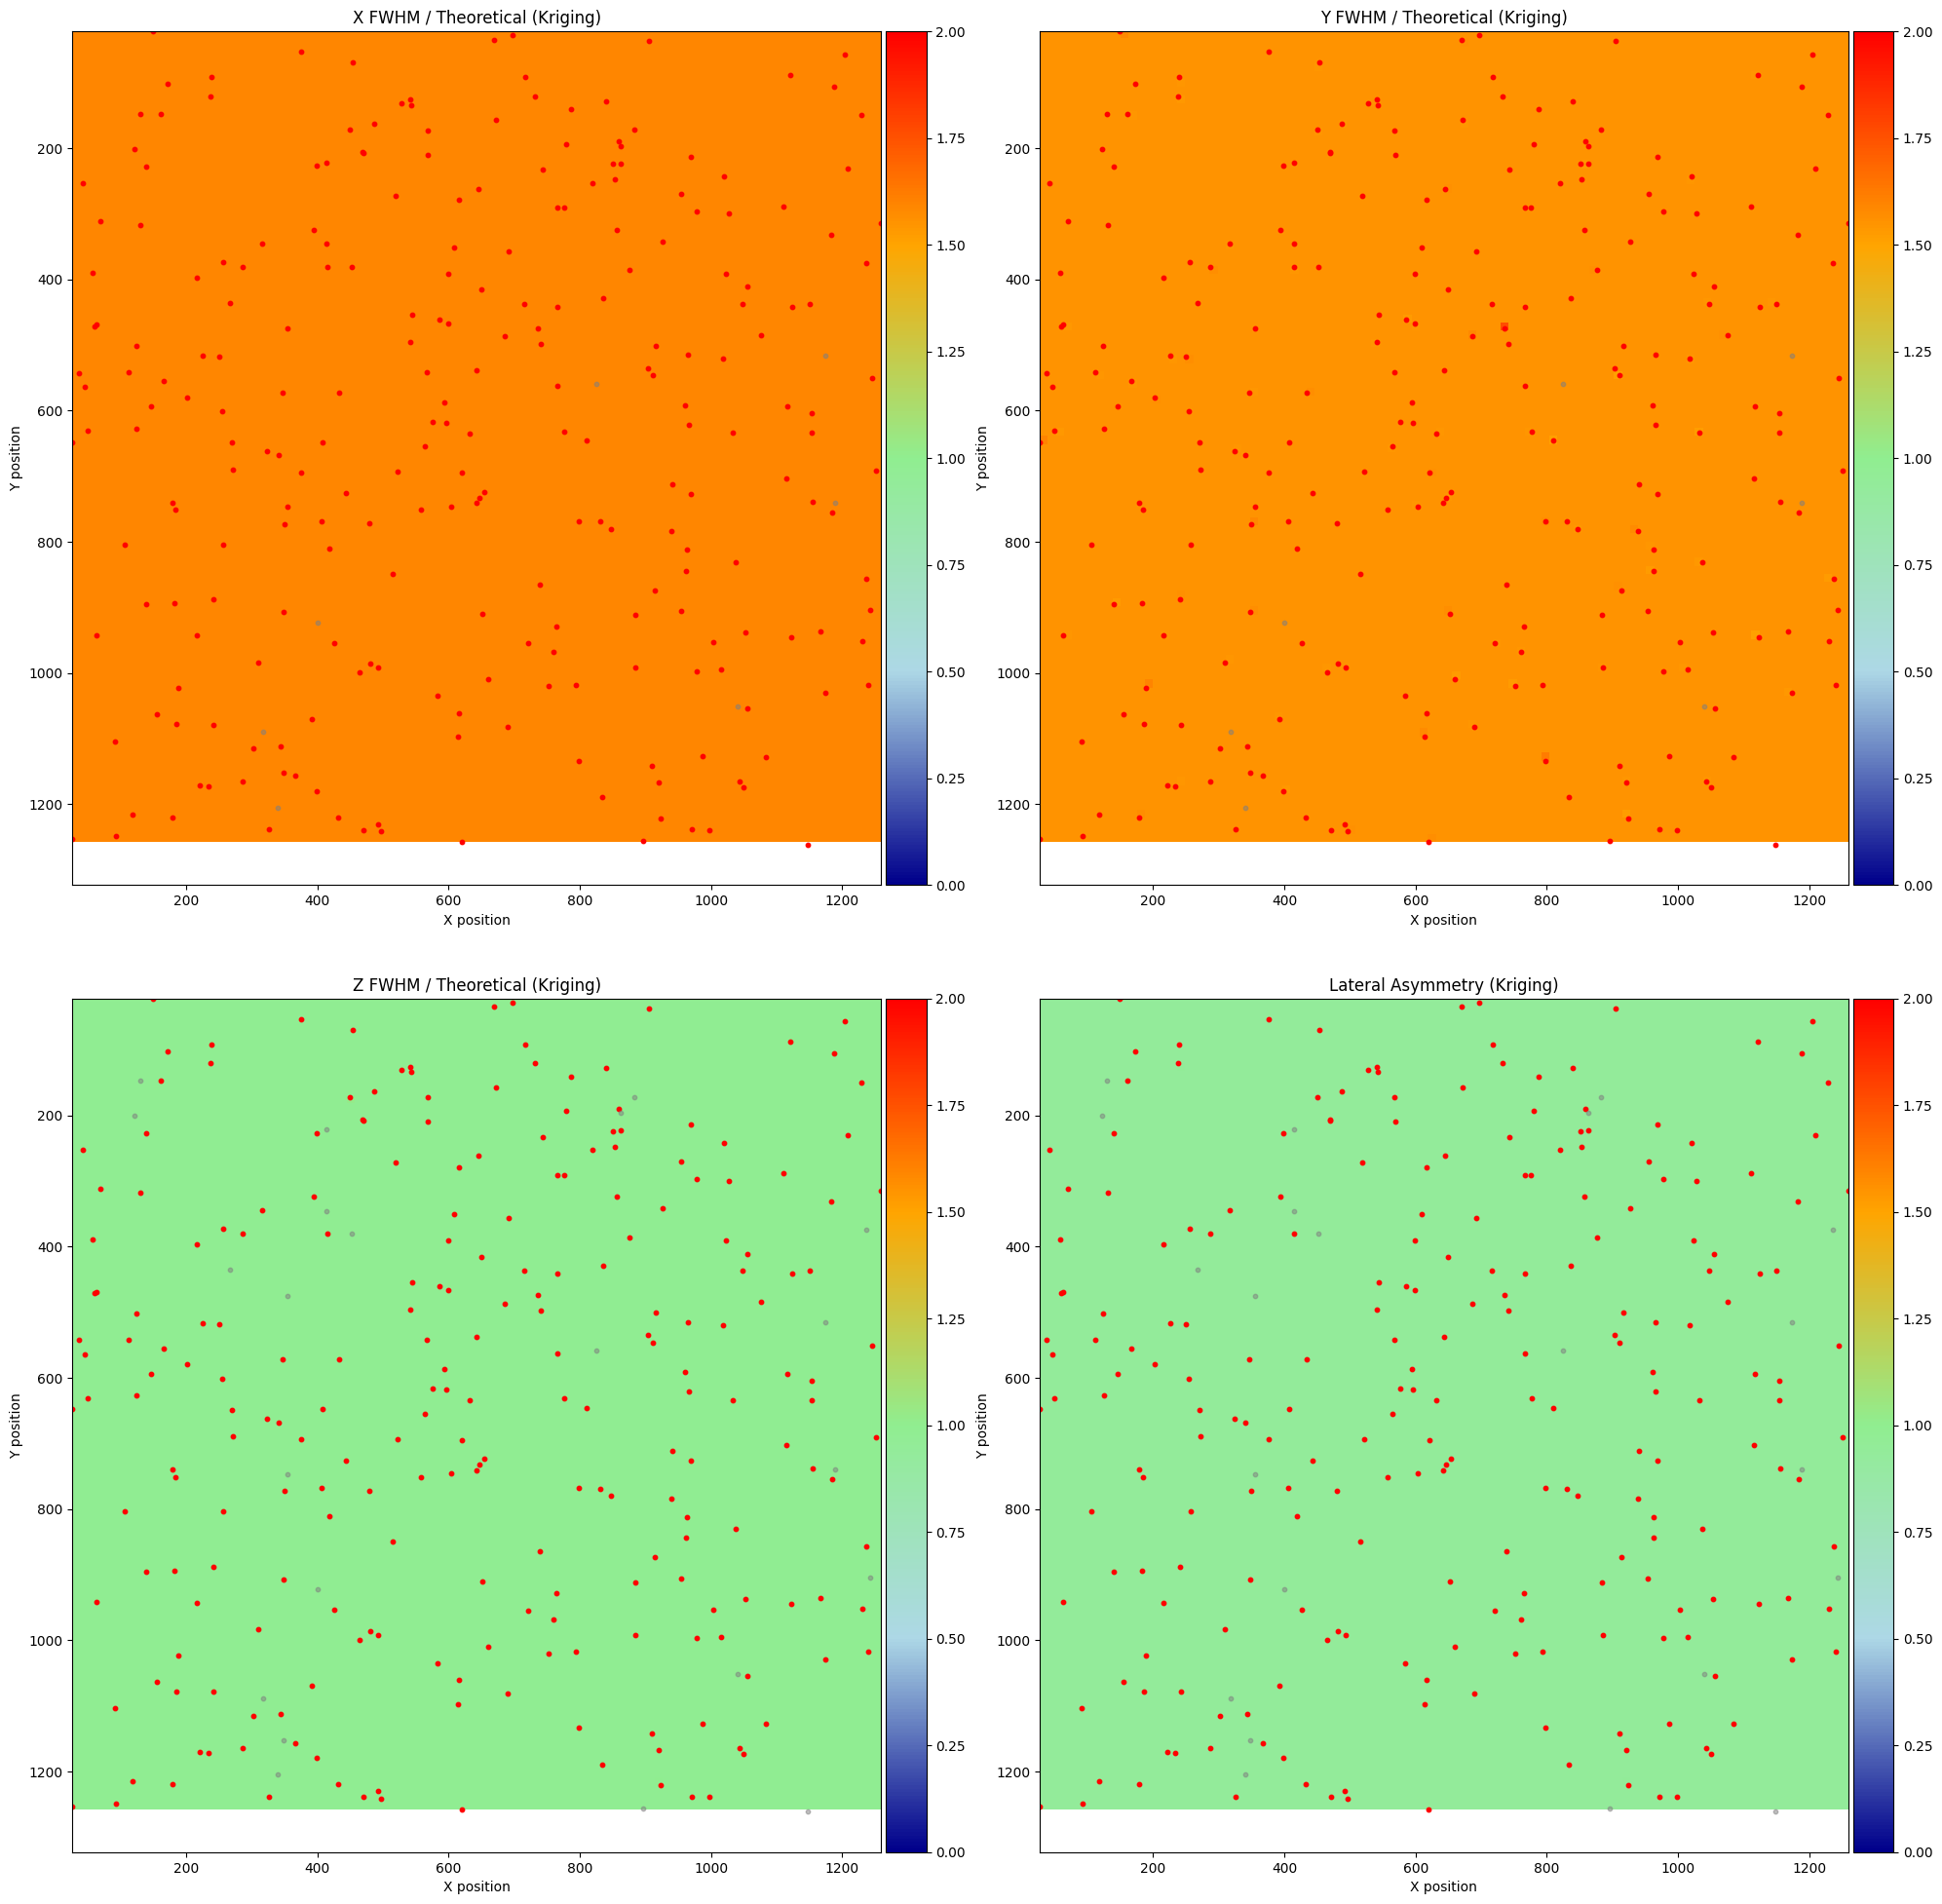

In [35]:
# Extract data from complete beads
x = np.array([bead["Bead coordinates (pixels)"]["X"] for bead in complete_beads])
y = np.array([bead["Bead coordinates (pixels)"]["Y"] for bead in complete_beads])
z_x = np.array([bead["Mes./theory ratio"]["X"] for bead in complete_beads])
z_y = np.array([bead["Mes./theory ratio"]["Y"] for bead in complete_beads])
z_z = np.array([bead["Mes./theory ratio"]["Z"] for bead in complete_beads])
z_lat = np.array([bead["Lateral Asymmetry"] for bead in complete_beads])

# Precompute min and max for x and y
x_min, x_max = min(x), max(x)
y_min, y_max = min(y), max(y)

# Create meshgrid for interpolation
xi, yi = np.meshgrid(np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))

# Function to perform Kriging interpolation
def kriging_interpolation(x, y, z_values, xi, yi):
    OK = OrdinaryKriging(x, y, z_values, variogram_model=variogram_model, verbose=False, enable_plotting=False)
    zi, ss = OK.execute('grid', np.linspace(x_min, x_max, 100), np.linspace(y_min, y_max, 100))
    return zi

# Perform Kriging interpolation
zi_x = kriging_interpolation(x, y, z_x, xi, yi)
zi_y = kriging_interpolation(x, y, z_y, xi, yi)
zi_z = kriging_interpolation(x, y, z_z, xi, yi)
zi_lat = kriging_interpolation(x, y, z_lat, xi, yi)

# Plotting function
def plot_heatmap(ax, zi, title, z_values):
    im = ax.imshow(zi, extent=[x_min, x_max, y_max, y_min], origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')

    # Scatter plot for complete beads
    ax.scatter(x, y, c='red', s=10, label='Complete data')

    # Scatter plot for incomplete beads
    for bead in incomplete_beads:
        if "X" in bead["Bead coordinates (pixels)"] and "Y" in bead["Bead coordinates (pixels)"]:
            if title.split()[0] in bead["Mes./theory ratio"] or (title == "Lateral Asymmetry" and bead["Lateral Asymmetry"] is not None):
                ax.scatter(bead["Bead coordinates (pixels)"]["X"], bead["Bead coordinates (pixels)"]["Y"], c='red', s=10)
            else:
                ax.scatter(bead["Bead coordinates (pixels)"]["X"], bead["Bead coordinates (pixels)"]["Y"], c='gray', s=10, alpha=0.5)

    # Add colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

# Plot the four heatmaps with Kriging interpolation
plot_heatmap(axs[0, 0], zi_x, 'X FWHM / Theoretical (Kriging)', z_x)
plot_heatmap(axs[0, 1], zi_y, 'Y FWHM / Theoretical (Kriging)', z_y)
plot_heatmap(axs[1, 0], zi_z, 'Z FWHM / Theoretical (Kriging)', z_z)
plot_heatmap(axs[1, 1], zi_lat, 'Lateral Asymmetry (Kriging)', z_lat)

# Tight layout for spacing
plt.tight_layout()
plt.show()


In [32]:
method='cubic' #linear etc

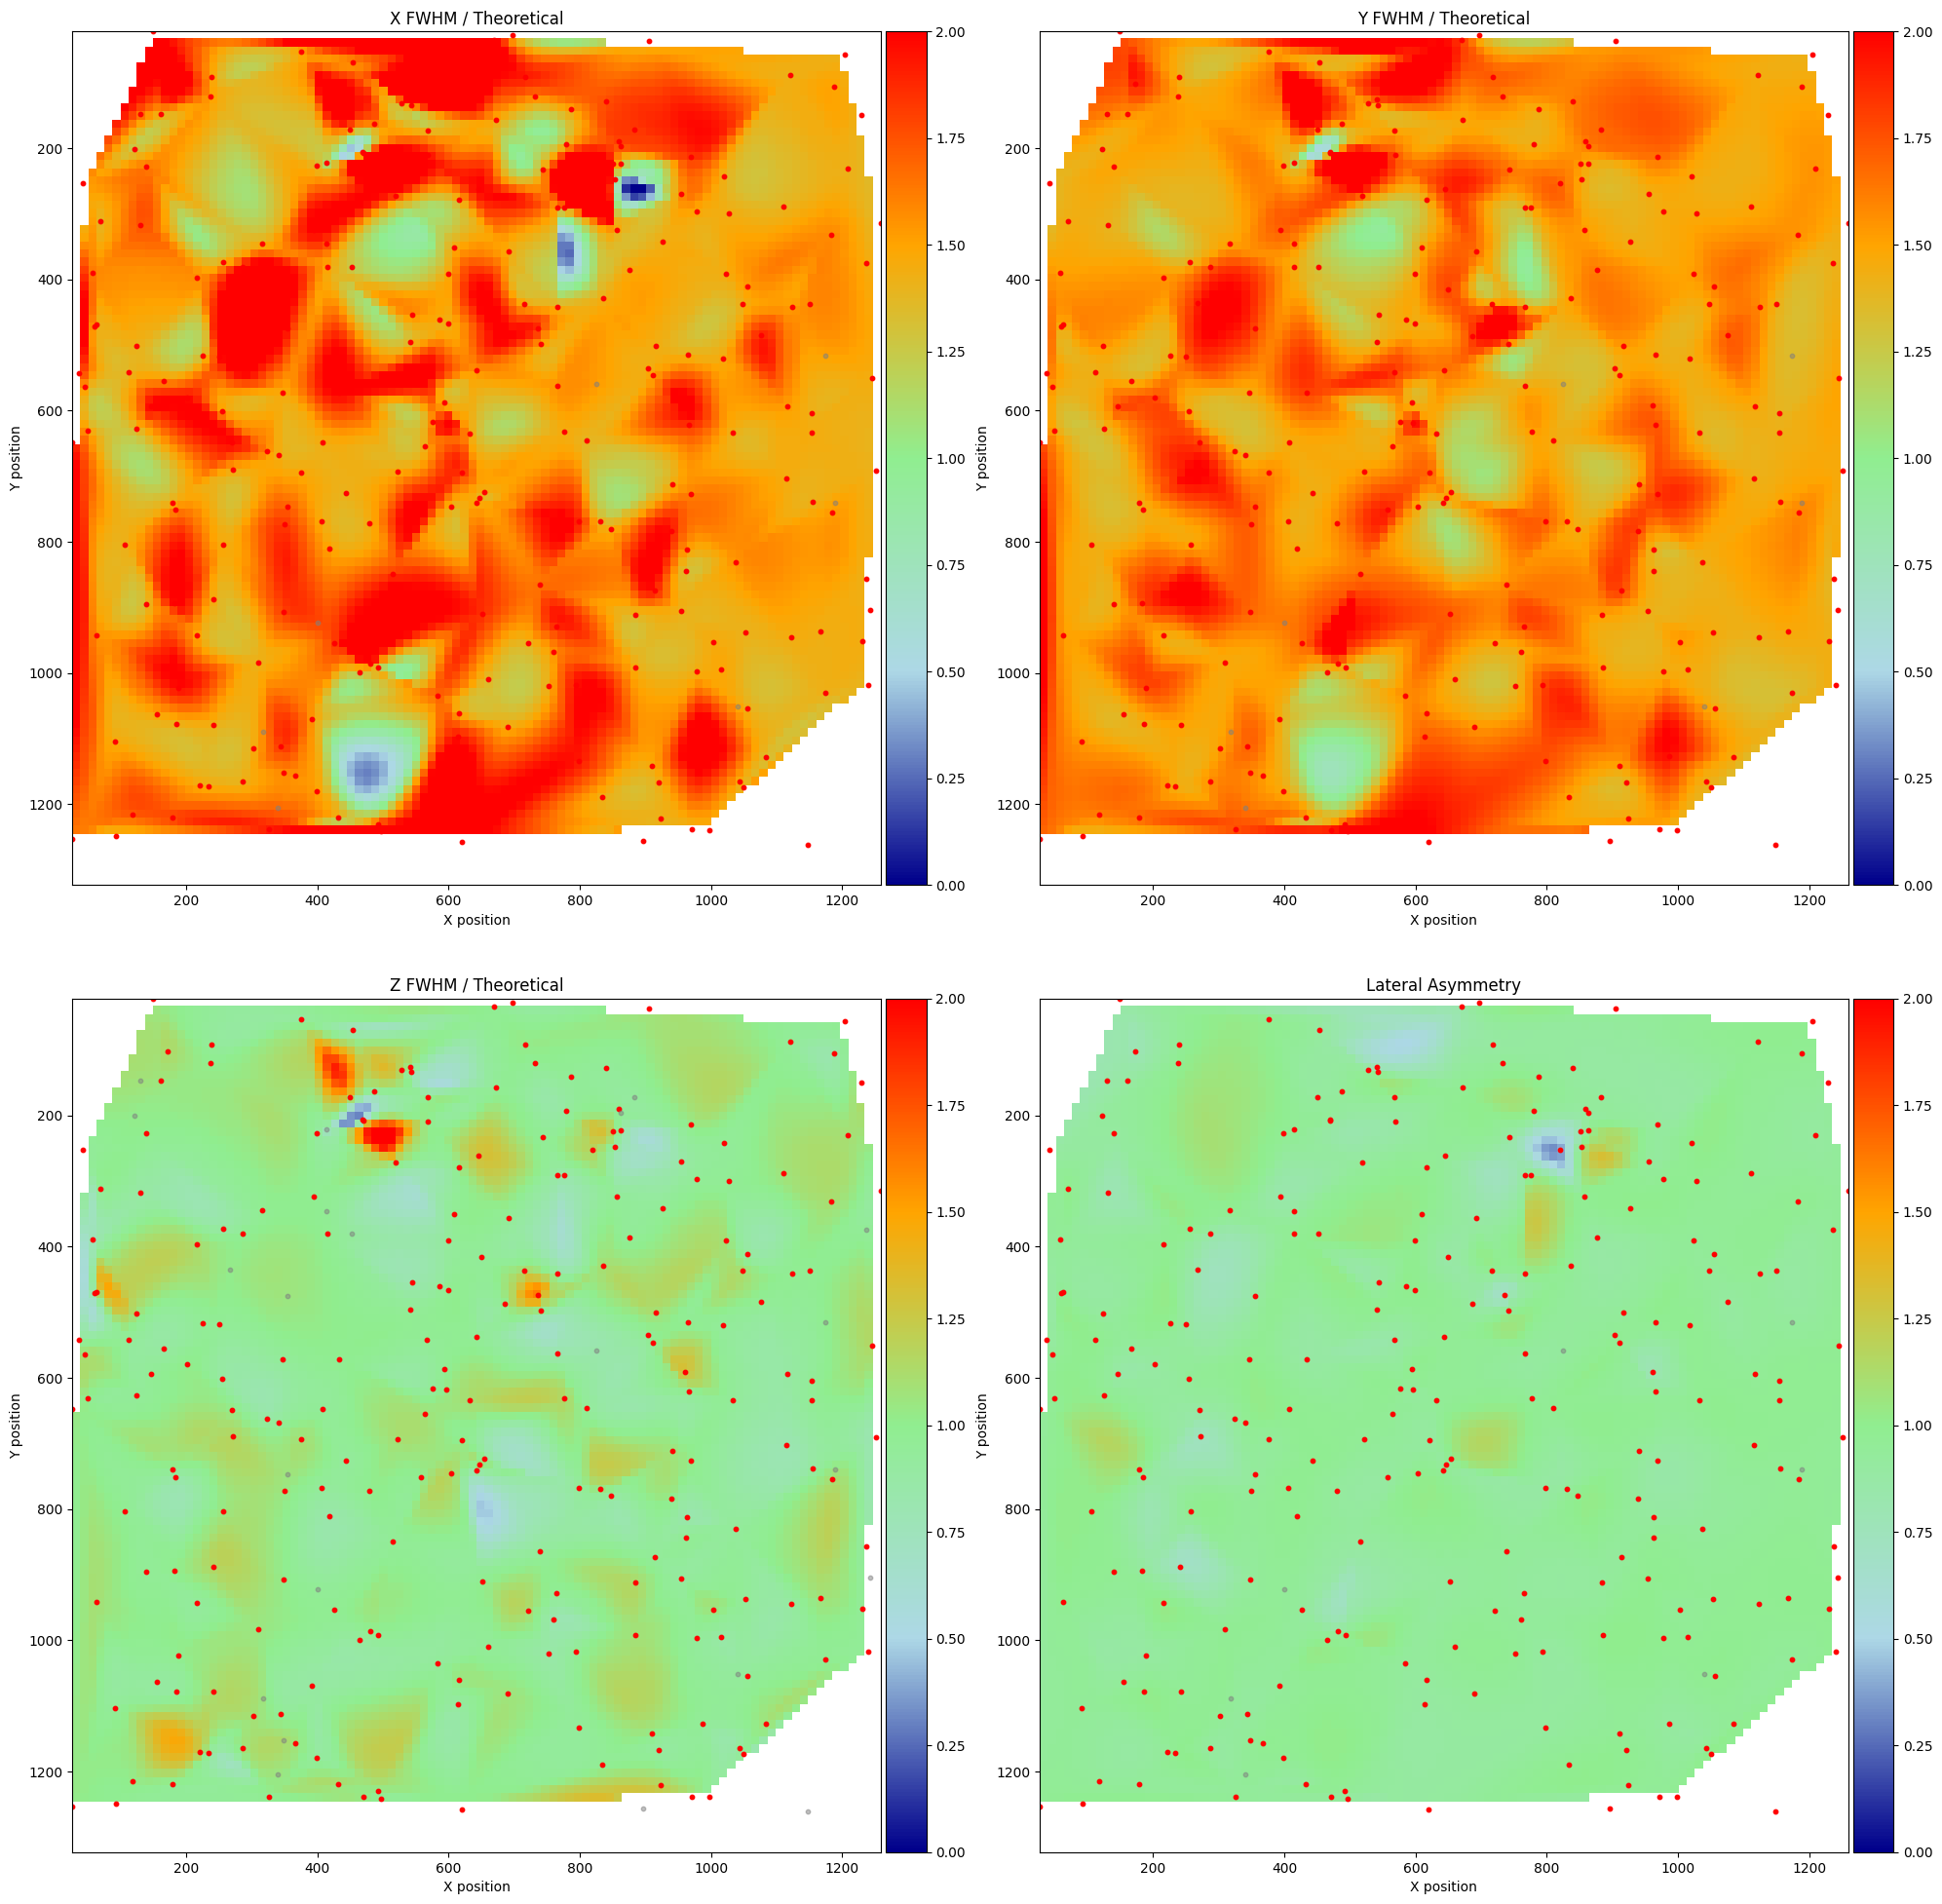

In [33]:
# Extract data
x = [bead["Bead coordinates (pixels)"]["X"] for bead in complete_beads]
y = [bead["Bead coordinates (pixels)"]["Y"] for bead in complete_beads]
z_x = [bead["Mes./theory ratio"]["X"] for bead in complete_beads]
z_y = [bead["Mes./theory ratio"]["Y"] for bead in complete_beads]
z_z = [bead["Mes./theory ratio"]["Z"] for bead in complete_beads]
z_lat = [bead["Lateral Asymmetry"] for bead in complete_beads]

# Create meshgrid
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate data
zi_x = griddata((x, y), z_x, (xi, yi), method=method)
zi_y = griddata((x, y), z_y, (xi, yi), method=method)
zi_z = griddata((x, y), z_z, (xi, yi), method=method)
zi_lat = griddata((x, y), z_lat, (xi, yi), method=method)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    
def plot_heatmap(ax, zi, title, z_values):
    im = ax.imshow(zi, extent=[min(x), max(x), max(y), min(y)], origin='upper', cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')

    # Plot complete data
    ax.scatter(x, y, c='red', s=10, label='Complete data')

    # Plot incomplete data
    for bead in incomplete_beads:
        if "X" in bead["Bead coordinates (pixels)"] and "Y" in bead["Bead coordinates (pixels)"]:
            if title.split()[0] in bead["Mes./theory ratio"] or (title == "Lateral Asymmetry" and bead["Lateral Asymmetry"] is not None):
                ax.scatter(bead["Bead coordinates (pixels)"]["X"], bead["Bead coordinates (pixels)"]["Y"], c='red', s=10)
            else:
                ax.scatter(bead["Bead coordinates (pixels)"]["X"], bead["Bead coordinates (pixels)"]["Y"], c='gray', s=10, alpha=0.5)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

# Plot heatmaps
plot_heatmap(axs[0, 0], zi_x, 'X FWHM / Theoretical', z_x)
plot_heatmap(axs[0, 1], zi_y, 'Y FWHM / Theoretical', z_y)
plot_heatmap(axs[1, 0], zi_z, 'Z FWHM / Theoretical', z_z)
plot_heatmap(axs[1, 1], zi_lat, 'Lateral Asymmetry', z_lat)

plt.tight_layout()
plt.show()